In [1]:
import pandas as pd
import wget
import os
import lmfit
from lmfit.models import StepModel, ExponentialModel, PolynomialModel


DataSource = 'OurWorldData'

if DataSource == 'JohnHopkins':
    fname = 'time_series_19-covid-Confirmed.csv'

    if os.path.exists(fname):
        os.remove(fname)

    ddir = 'data/'
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
    ff = wget.download(url)
    print (ff)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'

    dd = pd.read_csv(ff)

else:
    fname = 'full_data.csv'
    if os.path.exists(fname):
        os.remove(fname)
    
    url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
    ff = wget.download(url)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'
    dd = pd.read_csv(ff, parse_dates = ['date'])
    
    
## Data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series



In [2]:
dd['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar',
       'Greece', 'Greenland', 'Guam', 'Guatemala', 'Guerns

In [3]:
dd['date'][0] 

Timestamp('2019-12-31 00:00:00')

           date     location  new_cases  new_deaths  total_cases  total_deaths
4101 2019-12-31  New Zealand          0           0            0             0
4102 2020-01-01  New Zealand          0           0            0             0
4103 2020-01-02  New Zealand          0           0            0             0
4104 2020-01-03  New Zealand          0           0            0             0
4105 2020-01-04  New Zealand          0           0            0             0
...         ...          ...        ...         ...          ...           ...
4170 2020-03-18  New Zealand         12           0           20             0
4171 2020-03-19  New Zealand          8           0           28             0
4172 2020-03-20  New Zealand         11           0           39             0
4173 2020-03-21  New Zealand         14           0           53             0
4174 2020-03-22  New Zealand         13           0           66             0

[74 rows x 6 columns]
2020-03-02 00:00:00 62
New Ze

/mnt/DATA/anaconda3/envs/covid/lib/python3.6/site-packages/lmfit/lineshapes.py:323: RuntimeWarning: overflow encountered in exp
  out = (1. - 1./(1. + exp(out)))


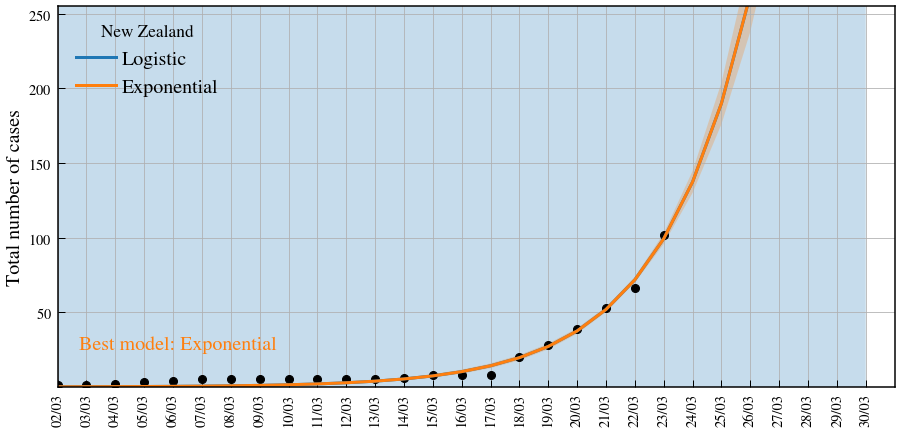

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

countries = ['New Zealand']#,'Chile','Italy','Spain']
ncountries = len(countries)
models= {'Logistic': StepModel(form='logistic'), 
        'Exponential': ExponentialModel() }#,
        #'3rd deg. Polynomial': PolynomialModel(degree=3)}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, axs = plt.subplots(ncountries,figsize=(15,ncountries*7))
plt.rcParams['legend.title_fontsize'] = 'xx-large'

countryvar = 'location' if DataSource == 'OurWorldData' else 'Country/Region'

for icc,country in enumerate(countries):

    sel = dd[countryvar] == country
    dc = dd.loc[sel]
    print (dc)
    cols = list(dc.columns)
    dates = cols[4:] if DataSource == 'JohnHopkins' else dc['date'].reset_index(drop=True)

    if DataSource == 'JohnHopkins':
        nn = []
        for i in dates:
            nn.append(dc[i].to_numpy()[0])
    else:
        nn = dc['total_cases'].reset_index(drop=True).to_numpy()
        
    xstart = 0
    
    for ii, inn in enumerate(list(nn)):
        if inn > 1:
            xstart = ii-1 if ii > 1 else 0
            break
#    import pdb ; pdb.set_trace()        
    nn = nn[xstart:]
    print (dates.iloc[xstart], xstart)
    dates = dates.iloc[xstart:].reset_index(drop=True)
    
    # ensuring data completeness    
    dates_all = pd.date_range(start=dates.iloc[0], end=dates.iloc[-1])
    ntotal = [] #np.zeros(len(dates_all))
    iid = 0
    for ixx, idate in enumerate(dates_all):
        if dates.iloc[iid] == idate:
            ntotal.append(nn[iid])
            iid += 1
        else:
            ntotal.append(ntotal[ixx-1])
    
    #import pdb ; pdb.set_trace()
    add_data_manually = True  # to add latest info not in the database yet
    
    if add_data_manually:
        if country == 'Chile':
            ntotal.append(632)
            dates_all = pd.date_range(start=dates.iloc[0], periods = len(dates_all)+1)
        if country == 'New Zealand':
            ntotal.append(102)
            dates_all = pd.date_range(start=dates.iloc[0], periods = len(dates_all)+1)
    
    nn = ntotal
    dates = dates_all
    xstart = 0

    print (country, xstart)
    ndata = len(nn)
    nn = np.array(nn)
    xx = np.arange(0,ndata)
    xxx = np.arange(0,ndata+7)
    nper = len(xxx)
    print (country, nper)
    xxxx = np.arange(0,ndata+7)# if nper < 100 else 2)
    datesxxx = pd.date_range(start=dates[0], periods=nper).strftime('%d/%m')
    
    #import pdb ; pdb.set_trace()    
    
    print (datesxxx)
    
    if ncountries > 1:
        ax = axs[icc]
    else:
        ax = axs

    
    ax.set_xticks(xxxx)
    ax.set_xticklabels(datesxxx[xxxx], rotation='vertical')
    ax.plot(xx,nn,'ko',markersize=8)
    #ax.set_yscale('log')

    icol = 0 
    ixx = np.where(nn > 10)[0] if country == 'Spain' else np.where(nn > 8)[0]
    bics = []
    mn = []
    
    for mname, model in models.items():
       
        pars0 = model.guess(nn[ixx], x=xx[ixx])
        out = model.fit(nn[ixx], pars0, x=xx[ixx])
        pars = out.params
        bics.append(out.bic)
        mn.append(mname)
 
        dely = out.eval_uncertainty(x=xxx)
        y =  out.eval(pars,x=xxx)        
        ax.plot(xxx,y, '-', label=f'{mname}', color=colors[icol],linewidth=3)
        ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.25)
        icol += 1
        
       # print (mname, country, y[len(xx) + 11], bics[-1])
    
    bic = np.argmin(bics)
    ax.text(0.025,0.1,f'Best model: {mn[bic]}', fontsize=20,
           transform=ax.transAxes, color= colors[bic])


    ax.set_xlim([0,ndata + 7])
    ax.set_ylim([0.1,np.min([100000, np.max(nn)*2.5])])
    ax.ticklabel_format(axis='y', style='sci',useMathText=True, scilimits=(0,5))
    ax.set_ylabel('Total number of cases',fontsize=20)
    ax.legend(title=country, fontsize=20,loc='upper left')
    ax.grid()
    

plt.show()


#popt2, pcov2 = curve_fit(sigmoid, np.arange(ndata), nn, sigma= err,p0=[.001, .1,.1],absolute_sigma=True)


#print (popt)

In [5]:
data = 'data/Metadata_Indicator_API_EN.POP.DNST_DS2_en_csv_v2_887474.csv'
df = pd.read_csv(data)
df

,INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION,Unnamed: 4
0,EN.POP.DNST,Population density (people per sq. km of land ...,Population density is midyear population divid...,Food and Agriculture Organization and World Ba...,NaN


In [6]:

d




NameError: name 'd' is not defined